In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import optimizers

%matplotlib inline

In [ ]:
df_full = pd.read_csv('15marchlatestcsv.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


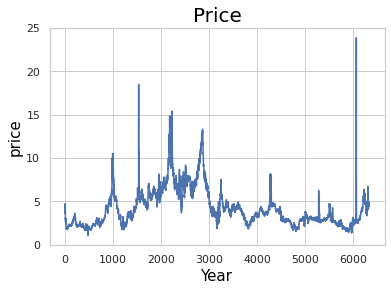

In [ ]:
df_full['Price'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('price', color = 'black', fontsize = 15);

In [ ]:


df = df_full[['Price']]

In [ ]:
df

,Price
0,3.82
1,3.80
2,3.61
3,3.92
4,4.00
...,...
6331,4.55
6332,4.65
6333,4.79
6334,4.59


In [ ]:
df.isnull().any()
df.fillna(method="pad")
df.isnull().any()
df.columns[df.isna().any()].tolist()
df.loc[:, df.isna().any()]

df.loc[5284]['Price'] = df.loc[5283]['Price']
df[df.isna().any(axis=1)]

,Price


## 4. Create training data set

In [ ]:
# Convert DataFrame to numpy array
df_arr = df.values

training_data_len = 6285

training_data_len

6285

In [ ]:
# Create train data set

train = df_arr[0:training_data_len, :]

In [ ]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train).astype('float32')

train_scaled

array([[0.12143797],
       [0.12056116],
       [0.11223148],
       ...,
       [0.09951776],
       [0.10302499],
       [0.12143797]], dtype=float32)

In [ ]:
train_scaled.shape

(6285, 1)

## Split training data into X_train, y_train

In [ ]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

[array([0.12143797, 0.12056116, 0.11223148, 0.12582201, 0.12932923,
       0.12976764, 0.14423499, 0.16045594, 0.1253836 , 0.09688733,
       0.08505042, 0.08768084, 0.08373521, 0.06882946, 0.08461201,
       0.08768084, 0.08154318, 0.07935116, 0.07540552, 0.06313021,
       0.06751425, 0.07014468, 0.06400701, 0.05874616, 0.06006138,
       0.05655414, 0.06006138, 0.05129329, 0.04690925, 0.03463393,
       0.03945638, 0.03814116, 0.03814116, 0.03814116, 0.0315651 ,
       0.03331872, 0.03288032, 0.03200351, 0.03288032, 0.03594914,
       0.03814116, 0.03375712, 0.03682595, 0.03945638, 0.03814116,
       0.03989478, 0.04077159, 0.04033319, 0.0420868 , 0.03770276,
       0.03638755, 0.03638755, 0.03594914, 0.03288032, 0.03507234,
       0.03507234, 0.03463393, 0.03463393, 0.03945638, 0.03507234],
      dtype=float32)]
[array([0.03594914], dtype=float32)]

[array([0.12143797, 0.12056116, 0.11223148, 0.12582201, 0.12932923,
       0.12976764, 0.14423499, 0.16045594, 0.1253836 , 0.09688733,

In [ ]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6225, 60, 1)

In [ ]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
# gradient clipping, might fix nan loss
optimizer = tf.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer, loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 500, batch_size = 64)

Epoch 1/500
98/98 [==============================] - 26s 157ms/step - loss: 0.0026
Epoch 2/500
98/98 [==============================] - 15s 155ms/step - loss: 0.0012
Epoch 3/500
98/98 [==============================] - 15s 154ms/step - loss: 0.0010
Epoch 4/500
98/98 [==============================] - 16s 165ms/step - loss: 9.0381e-04
Epoch 5/500
98/98 [==============================] - 15s 156ms/step - loss: 9.2815e-04
Epoch 6/500
98/98 [==============================] - 15s 155ms/step - loss: 8.6983e-04
Epoch 7/500
98/98 [==============================] - 15s 156ms/step - loss: 8.0854e-04
Epoch 8/500
98/98 [==============================] - 15s 157ms/step - loss: 7.7296e-04
Epoch 9/500
98/98 [==============================] - 15s 156ms/step - loss: 7.6251e-04
Epoch 10/500
98/98 [==============================] - 17s 174ms/step - loss: 6.9670e-04
Epoch 11/500
98/98 [==============================] - 15s 154ms/step - loss: 7.2408e-04
Epoch 12/500
98/98 [==============================] -

In [ ]:
# model = keras.models.load_model('/content/drive/MyDrive/sih22/tillDec2021')

In [ ]:
test = df_arr[training_data_len: , :]

In [ ]:
test.shape

(51, 1)

In [ ]:
# Predicting 253 values, using past 60 from the train data
inputs = df_arr[len(df_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [ ]:
# Create data sets X_test and y_test
X_test = []
y_test = df_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])


In [ ]:
# Convert data to numpy array
X_test = np.array(X_test)

In [ ]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_test.shape)

(51, 60, 1)


In [ ]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions.shape

(51, 1)

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

0.035769161897547065

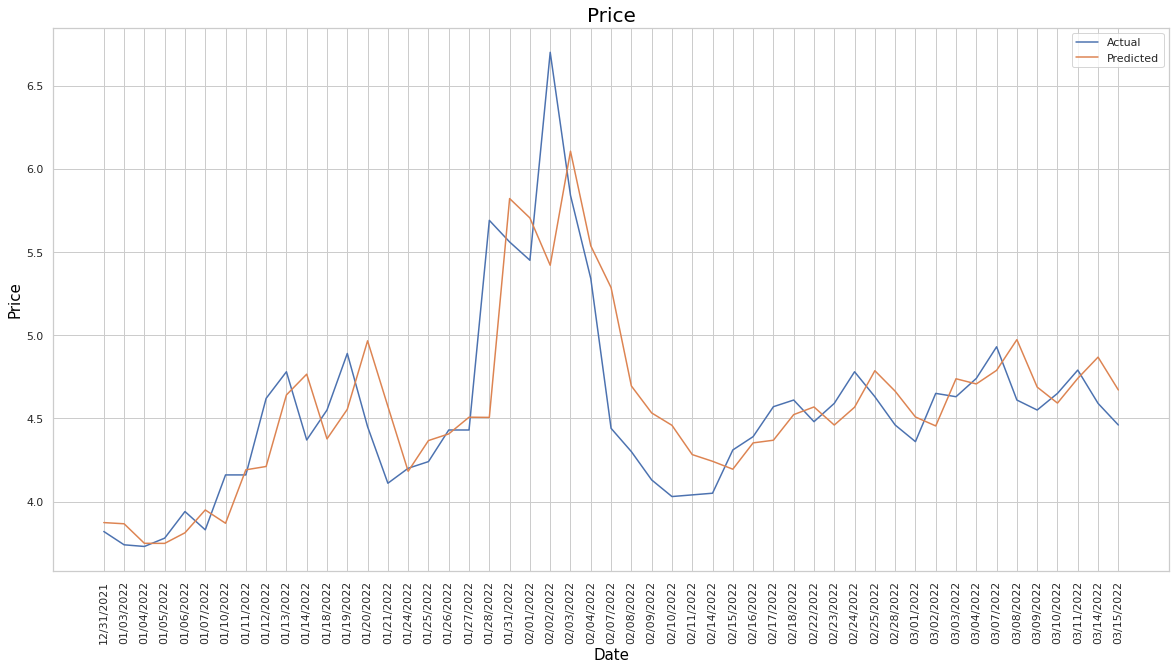

In [ ]:
# Plot predicted vs actual prices


import datetime


def intToDate(i, startDate):
  date = datetime.date(startDate[0], startDate[1], startDate[2])
  date = date + datetime.timedelta(days=i)
  return date

def isWeekday(date):
  return date.weekday() < 5


def indexToDate(startIndex, numVals, startDate):
  date = datetime.date(startDate[0], startDate[1], startDate[2])
  dates = []
  for i in range(numVals):
    if isWeekday(date):
      dates.append(date)
    date = date + datetime.timedelta(days=1)

  return dates

def fillMissing(df):
  df.set_index(pd.DatetimeIndex(df.Date), inplace=True)
  #fill date gaps
  df = df.resample('D').pad()
  #fix the Date column
  df.Date = df.index.values
  return df

dates = indexToDate(training_data_len, 66, (2021, 12, 31))
train = df[:training_data_len]
test = df_full[training_data_len:]
# print(test)
df_full.tail()

test['Predictions'] = predictions
# print(test)

# test[]







# # test['Date'] = dates
# # test.set_index('Date', inplace=True)
# test['Predictions'] = predictions
# # print(test)

# # print(fillMissing(df_full).tail(10))
# # test = fillMissing(test)

# test['Date'] = df_full[training_data_len: ]['Date']
# print(df_full[training_data_len: ]['Date'])
# test.set_index('Date', inplace=True)
# print(test)

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
# plt.plot(train['price'], label='Training')
plt.plot(test['Date'],test['Price'], label='Actual')
plt.plot(test['Date'],test['Predictions'], label='Predicted')
plt.title("Price", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.xticks(rotation=90)
plt.legend();

### DataFrame of actual vs predicted prices plotted above

In [ ]:
# Show the actual and predicted prices  

test

,Date,Price,Predictions
6285,12/31/2021,3.82,3.873469
6286,01/03/2022,3.74,3.866374
6287,01/04/2022,3.73,3.748975
6288,01/05/2022,3.78,3.748580
6289,01/06/2022,3.94,3.812207
6290,01/07/2022,3.83,3.949525
6291,01/10/2022,4.16,3.869475
6292,01/11/2022,4.16,4.190687
6293,01/12/2022,4.62,4.210700
6294,01/13/2022,4.78,4.640569


In [ ]:
model.save("/content/drive/MyDrive/sih22/tillDec2021-500epo")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sih22/tillDec2021-500epo/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sih22/tillDec2021-500epo/assets


The predicted Adjusted Close price for 11 July 2019 was 5829.4, lower than the actual price of 6024.7. Accuracy could be improved by trying different numbers of layers, epochs and batch sizes. 